# Data Wrangling-Lending Club Data 2015Q1-2017Q4 #

##The purpose of this exercise is to inspect and clean the lending club data so that it is ready for my capstone project ##

In [ ]:
#I WILL TYPE UP MY REPORT HERE, USING THE COMMENTS ALREADY WRITTEN IN THIS NOTEBOOK. I WILL COLLATE THEM
#change
#let's call .info() on all the columns in order to find null or mostly-null columns
loan16q1.iloc[:,0:100].info()
loan16q1.iloc[:,101:len(loan16q1.columns)].info()
#id, member_id, url, desc, revol_bal_joint, sec_app_earliest_cr_line, sec_app_inq_last_6mths, sec_app_mort_acc,
#sec_app_open_acc, sec_app_revol_util, sec_app_open_act_il, sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths, 
#sec_app_collections_12_mths_ex_med, and sec_app_mths_since_last_major_derog are all entirely null 
#or almost entirely null values. Let's remove these columns.
#annual_inc_joint, dti_joint, verification_status_joint columns have at most 2661 non-null values.    
#hardship_type through hardship_last_payment_amount columns have at most 1009 non-null values.

#let's drop the null columns. these columns have zero or very few actual values
coldrplist = ['id', 'member_id', 'url', 'desc', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths', 
'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog']

loan16q1.drop(loan16q1.loc[:, coldrplist], inplace=True, axis=1)
loan16q1 = loan16q1.drop(loan16q1.index[-2:]) #these rows are making all columns display NaN as a unique value,
#so we should remove them

#there are too many columns to analyze. we need to narrow down the dataframe.
#let's ascertain the variables we will work with.

#now we narrow down the dataframe to a manageable subset of about 25 columns of interest. loan_status will
#be our target variable. the other variables (such as grade, annual_inc, etc.) all seem to be relevant and 
#useful for predicting loan_status
var_of_interest = ['loan_amnt','int_rate','grade','emp_length','home_ownership',
'annual_inc','verification_status','loan_status','purpose','zip_code','addr_state','num_bc_tl',
'num_il_tl','num_rev_accts','dti','delinq_2yrs','pub_rec_bankruptcies','all_util','tax_liens',
'num_accts_ever_120_pd','pct_tl_nvr_dlq','percent_bc_gt_75','inq_last_12m','mo_sin_rcnt_tl']

loan_subset = loan16q1.loc[:,var_of_interest]

print(loan_subset.head())

#int_rate was loaded in as an object type variable when it should be float type. let's write some code here to remove 
#the '%' symbol from the int_rate column and change the column type from object to float type

# '%' is in the last position for each row, so we can access it this way
loan_subset['int_rate'] = loan_subset['int_rate'].str[:-1] 

#now that the percent sign is gone, we can convert the column to float
loan_subset['int_rate'] = loan_subset['int_rate'].astype('float')

print(loan_subset['int_rate'].head())
print(loan_subset[['int_rate']].describe()) #int_rate is now of float type

#printing the dataframe also reveals that emp_length is represented as a categorical rather than numerical variable
#it would be more intuitive to convert these categories to their associated integer values
loan_subset['emp_length'].value_counts() #unique category value counts before

#we will replace n/a values for emp_length with 'N/A'

#replace emp_length na's with 'N/A' based on emp_length == 'n/a'
loan_subset.loc[loan_subset['emp_length'] == 'n/a', 'emp_length'] = 'N/A'

print(loan_subset['emp_length'].value_counts())


#Now let's convert the emp_length categories into numerical data. For example, 10+ years = 10, 2 years = 2, etc.
#In addition, we will convert 'N/A' values to zero. Through both of these steps we lose some information because N/A 
#may not necessarily equal zero, '< 1 year' never equals 1 (although it will frequently be close),
#and '10+ years' won't always equal 10. What we are doing here is called 'censoring', i.e., data points are above (10 years)
#or below (1 year) a certain value, but it is unknown by how much.
loan_subset.replace('N/A', np.nan,inplace=True)
loan_subset.emp_length.fillna(value=0,inplace=True)
loan_subset['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_subset['emp_length'] = loan_subset['emp_length'].astype(int)


print(loan_subset['emp_length'].value_counts())

#as can be seen in the earlier printout of loan16q1.info(), there are numerous NaN values.
#now we begin the process of NaN removal 

#get amount of nan values in each column
print(loan_subset.isnull().sum())

#there are 1129 NaN values for percent_bc_gt_75. however, this can explained by the fact that some
#borrowers probably don't have bankcard accounts. if rows with NaN for percent_bc_gt_75 also display the value 0 
#for number of bankcard accounts (num_bc_tl), then we should replace NaN with the value 0 for percent_bc_gt_75.
print(loan_subset[(loan_subset['percent_bc_gt_75'].isnull()) & (loan_subset['num_bc_tl'] == 0)])

#there are 241 rows that meet this condition. we should therefore relabel NaN as 0 for these instances of percent_bc_gt_75

print(loan_subset.isnull().sum()) #we have much fewer NaN values now. let's remove the all the rows with the remaining NaN values
print(loan_subset.count()) #as can be seen, the total amount of rows with NaN values (1034) is less than 1% of the entire row 
#count 133887. it will likely not result in a huge loss of information if we delete these rows entirely. we will also plot 
#describe() for selected variables in order to see if mean,min,max, etc. have changed significantly as a result of row removal.


#let's print out descriptive statistics for selected columns to see if there is any significant effect on the 
#statistics as a result of removing all the remaining rows with NaN values. These are the stats before NaN removal:
#let's create a sublist of the selected columns

#example of how to remove all nan values from a column
#x = loan16q1[['settlement_date']]
#y= x.dropna(how = 'any')
#print(y)

#loop through loan_subset using var_of_interest variable list to determine which columns have nan values.
#we will drop all remaining rows with NaN values from the entire loan_subset dataframe instead of replacing
#the NaNs with  alternative values

#now we will print out descriptive statistics for selected columns to see if there is any significant effect on the 
#statistics as a result of removing all the remaining rows with NaN values. These are the stats after NaN removal:
#let's create a sublist of the selected columns

var_sublist_after = ['loan_amnt','int_rate','grade','annual_inc','loan_status','purpose','dti','delinq_2yrs','pub_rec_bankruptcies',
'all_util','num_accts_ever_120_pd','percent_bc_gt_75']

for col in var_sublist_after:
    print(loan_subset[[col]].describe())
    
#a review of the descriptive statistics for the selected columns before and after NaN row removal reveals little change in the
#mean,std, min, etc. measures. the only real noticeable difference is that minimum value for annual_inc is now $200 instead of 0.
#in the context of such a large dataset that includes large income values into the millions of dollars,
#this is an inconsequential change.


#let's plot histograms of all the numerical variables to inspect for possible problematic outliers
non_categorical_vars =['loan_amnt','int_rate','annual_inc','emp_length','dti','delinq_2yrs','pub_rec_bankruptcies',
'all_util','num_accts_ever_120_pd','percent_bc_gt_75','num_bc_tl','num_il_tl','num_rev_accts','tax_liens','pct_tl_nvr_dlq',
'inq_last_12m','mo_sin_rcnt_tl']


for i in non_categorical_vars:
    print(str(i))
    print(loan_subset[i].plot(kind = 'hist'))
    plt.show()

    

#through inspection of the histograms in addition to descriptive statistics provided in the previous cell, it is
#obvious that outliers are present for most of the variables. However, these outliers don't appear to be a result
#of data entry error, but rather as a result of random variation. For example, annual income has a large outlier 
#for the maximum value, but that is logical because some people have large annual incomes. Moreover, in spite of
#these outliers, the median and mean values for all of the variables track closely together, indicating that these
#large values don't distort the central tendency that much. It is important to note however, that virtually of the
#distributions are positively skewed; this is due to the fact that none of these variables can ever be less than zero.
#for example, annual income, number of accounts 120 past due, number of bankruptcies, etc. can never be negative.
#In addition, we are dealing with a lot of imbalanced data; there are generally going to be many more zero values than
#values above zero for variables like pub_rec_bankruptcies, num_accts_ever_120_pd, delinq_2yrs, tax_liens
#as these are generally rare events.
    
#upon review of each column, it appears that more changes are needed.
#zip_code has too many unique values to work with, and dti has a negative minimum value.
# We will group zip_code into regional categories by the first digit (7 = southwest,
#0 = northeast, etc.), and remove the negative value from dti.








In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cd Desktop\Springboard Course

C:\Users\William\Desktop\Springboard Course


In [3]:
#loan2015 = pd.read_csv('LoanStats2015.csv', header = 1)
loan16q1 = pd.read_csv('LoanStats_2016Q1.csv', header = 1)

#loan16q2 = pd.read_csv('LoanStats_2016Q2.csv', header = 1)
#loan16q3 = pd.read_csv('LoanStats_2016Q3.csv', header = 1)
#loan16q4 = pd.read_csv('LoanStats_2016Q4.csv', header = 1)
#loan17q1 = pd.read_csv('LoanStats_2017Q1.csv', header = 1)
#loan17q2 = pd.read_csv('LoanStats_2017Q2.csv', header = 1)
#loan17q3 = pd.read_csv('LoanStats_2017Q3.csv', header = 1)
#loan17q4 = pd.read_csv('LoanStats_2017Q4.csv', header = 1)
#print(loan2015.columns)


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#let's call .info() on all the columns in order to find null or mostly-null columns
loan16q1.iloc[:,0:100].info()
loan16q1.iloc[:,101:len(loan16q1.columns)].info()
#id, member_id, url, desc, revol_bal_joint, sec_app_earliest_cr_line, sec_app_inq_last_6mths, sec_app_mort_acc,
#sec_app_open_acc, sec_app_revol_util, sec_app_open_act_il, sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths, 
#sec_app_collections_12_mths_ex_med, and sec_app_mths_since_last_major_derog are all entirely null 
#or almost entirely null values. Let's remove these columns.
#annual_inc_joint, dti_joint, verification_status_joint columns have at most 2661 non-null values.    
#hardship_type through hardship_last_payment_amount columns have at most 1009 non-null values.

#loan16q1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133889 entries, 0 to 133888
Data columns (total 100 columns):
id                                2 non-null object
member_id                         0 non-null float64
loan_amnt                         133887 non-null float64
funded_amnt                       133887 non-null float64
funded_amnt_inv                   133887 non-null float64
term                              133887 non-null object
int_rate                          133887 non-null object
installment                       133887 non-null float64
grade                             133887 non-null object
sub_grade                         133887 non-null object
emp_title                         124906 non-null object
emp_length                        133887 non-null object
home_ownership                    133887 non-null object
annual_inc                        133887 non-null float64
verification_status               133887 non-null object
issue_d                           133

In [13]:
#let's drop the null columns. these columns have zero or very few actual values
coldrplist = ['id', 'member_id', 'url', 'desc', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths', 
'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog']

loan16q1.drop(loan16q1.loc[:, coldrplist], inplace=True, axis=1)
loan16q1 = loan16q1.drop(loan16q1.index[-2:]) #these rows are making all columns display NaN as a unique value,
#so we should remove them


In [ ]:
#there are too many columns to analyze. we need to narrow down the dataframe.
#let's ascertain the variables we will work with.

In [21]:
#now we narrow down the dataframe to a manageable subset of about 25 columns of interest. loan_status will
#be our target variable. the other variables (such as grade, annual_inc, etc.) all seem to be relevant and 
#useful for predicting loan_status
var_of_interest = ['loan_amnt','int_rate','grade','emp_length','home_ownership',
'annual_inc','verification_status','loan_status','purpose','zip_code','addr_state','num_bc_tl',
'num_il_tl','num_rev_accts','dti','delinq_2yrs','pub_rec_bankruptcies','all_util','tax_liens',
'num_accts_ever_120_pd','pct_tl_nvr_dlq','percent_bc_gt_75','inq_last_12m','mo_sin_rcnt_tl']

loan_subset = loan16q1.loc[:,var_of_interest]

print(loan_subset.head())

   loan_amnt int_rate grade emp_length home_ownership  annual_inc  \
0    25000.0   11.99%     C    2 years            OWN     76000.0   
1    10000.0   14.46%     C        n/a           RENT     49000.0   
2    34000.0   15.31%     C  10+ years       MORTGAGE    150000.0   
3    15000.0    9.75%     B    5 years           RENT     85500.0   
4    20000.0   11.47%     B    3 years           RENT     60000.0   

  verification_status         loan_status             purpose zip_code  \
0            Verified         Charged Off         credit_card    337xx   
1            Verified         Charged Off  debt_consolidation    142xx   
2     Source Verified  Late (31-120 days)  debt_consolidation    140xx   
3        Not Verified             Current         credit_card    606xx   
4        Not Verified             Current         credit_card    953xx   

        ...          dti  delinq_2yrs  pub_rec_bankruptcies  all_util  \
0       ...        28.83          0.0                   0.0      73

In [22]:
#int_rate was loaded in as an object type variable when it should be float type. let's write some code here to remove 
#the '%' symbol from the int_rate column and change the column type from object to float type

# '%' is in the last position for each row, so we can access it this way
loan_subset['int_rate'] = loan_subset['int_rate'].str[:-1] 

#now that the percent sign is gone, we can convert the column to float
loan_subset['int_rate'] = loan_subset['int_rate'].astype('float')

print(loan_subset['int_rate'].head())
print(loan_subset[['int_rate']].describe()) #int_rate is now of float type


,int_rate
count,133887.000000
mean,12.476372
std,4.829205
min,5.320000
25%,8.490000
50%,11.990000
75%,15.310000
max,28.990000


In [26]:
#printing the dataframe also reveals that emp_length is represented as a categorical rather than numerical variable
#it would be more intuitive to convert these categories to their associated integer values
loan_subset['emp_length'].value_counts() #unique category value counts before

#we will replace n/a values for emp_length with 'N/A'

#replace emp_length na's with 'N/A' based on emp_length == 'n/a'
loan_subset.loc[loan_subset['emp_length'] == 'n/a', 'emp_length'] = 'N/A'

print(loan_subset['emp_length'].value_counts())


#Now let's convert the emp_length categories into numerical data. For example, 10+ years = 10, 2 years = 2, etc.
#In addition, we will convert 'N/A' values to zero. Through both of these steps we lose some information because N/A 
#may not necessarily equal zero, '< 1 year' never equals 1 (although it will frequently be close),
#and '10+ years' won't always equal 10. What we are doing here is called 'censoring', i.e., data points are above (10 years)
#or below (1 year) a certain value, but it is unknown by how much.
loan_subset.replace('N/A', np.nan,inplace=True)
loan_subset.emp_length.fillna(value=0,inplace=True)
loan_subset['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_subset['emp_length'] = loan_subset['emp_length'].astype(int)


print(loan_subset['emp_length'].value_counts())

10+ years    46347
2 years      11849
3 years      10735
< 1 year     10082
N/A           8944
1 year        8703
5 years       8062
4 years       7789
8 years       6330
6 years       5379
9 years       5202
7 years       4465
Name: emp_length, dtype: int64
10    46347
1     18785
2     11849
3     10735
0      8944
5      8062
4      7789
8      6330
6      5379
9      5202
7      4465
Name: emp_length, dtype: int64


In [ ]:
#as can be seen in the earlier printout of loan16q1.info(), there are numerous NaN values.
#now we begin the process of NaN removal 

In [23]:
#get amount of nan values in each column
print(loan_subset.isnull().sum())

#there are 1129 NaN values for percent_bc_gt_75. however, this can explained by the fact that some
#borrowers probably don't have bankcard accounts. if rows with NaN for percent_bc_gt_75 also display the value 0 
#for number of bankcard accounts (num_bc_tl), then we should replace NaN with the value 0 for percent_bc_gt_75.
print(loan_subset[(loan_subset['percent_bc_gt_75'].isnull()) & (loan_subset['num_bc_tl'] == 0)])

#there are 241 rows that meet this condition. we should therefore relabel NaN as 0 for these instances of percent_bc_gt_75

loan_amnt                   0
int_rate                    0
grade                       0
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
zip_code                    0
addr_state                  0
num_bc_tl                   0
num_il_tl                   0
num_rev_accts               0
dti                        17
delinq_2yrs                 0
pub_rec_bankruptcies        0
all_util                   67
tax_liens                   0
num_accts_ever_120_pd       0
pct_tl_nvr_dlq              0
percent_bc_gt_75         1129
inq_last_12m               62
mo_sin_rcnt_tl              0
dtype: int64
        loan_amnt  int_rate grade emp_length home_ownership  annual_inc  \
421        5000.0     10.75     B  10+ years           RENT    25662.00   
498        8000.0     11.99     C   < 1 year           RENT    80000.00   
695        5000.0     16.29     D    4 yea

In [24]:
#replace NaN values in percent_bc_gt_75 with 0 when the conditions that percent_bc_gt_75 is null and num_bc_tl == 0 
#are both true
loan_subset.loc[np.logical_and(loan_subset['percent_bc_gt_75'].isnull(), loan_subset['num_bc_tl'] == 0), 'percent_bc_gt_75'] = 0

#reprinting the percent_bc_gt_75 column based on the two conditions afterwards confirms that the replacement worked.
#there are no more NaN values (when both these conditions are true)
print(loan_subset.loc[np.logical_and(loan_subset['percent_bc_gt_75'].isnull(), loan_subset['num_bc_tl'] == 0),'percent_bc_gt_75'])

print(loan_subset['percent_bc_gt_75'].isnull().sum()) #we saved 241 rows from deletion

Series([], Name: percent_bc_gt_75, dtype: float64)
888


In [27]:
loan_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133887 entries, 0 to 133886
Data columns (total 24 columns):
loan_amnt                133887 non-null float64
int_rate                 133887 non-null float64
grade                    133887 non-null object
emp_length               133887 non-null int32
home_ownership           133887 non-null object
annual_inc               133887 non-null float64
verification_status      133887 non-null object
loan_status              133887 non-null object
purpose                  133887 non-null object
zip_code                 133887 non-null object
addr_state               133887 non-null object
num_bc_tl                133887 non-null float64
num_il_tl                133887 non-null float64
num_rev_accts            133887 non-null float64
dti                      133870 non-null float64
delinq_2yrs              133887 non-null float64
pub_rec_bankruptcies     133887 non-null float64
all_util                 133820 non-null float64
tax_liens       

In [28]:
print(loan_subset.isnull().sum()) #we have much fewer NaN values now. let's remove the all the rows with the remaining NaN values
print(loan_subset.count()) #as can be seen, the total amount of rows with NaN values (1034) is less than 1% of the entire row 
#count 133887. it will likely not result in a huge loss of information if we delete these rows entirely. we will also plot 
#describe() for selected variables in order to see if mean,min,max, etc. have changed significantly as a result of row removal.

loan_amnt                  0
int_rate                   0
grade                      0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
zip_code                   0
addr_state                 0
num_bc_tl                  0
num_il_tl                  0
num_rev_accts              0
dti                       17
delinq_2yrs                0
pub_rec_bankruptcies       0
all_util                  67
tax_liens                  0
num_accts_ever_120_pd      0
pct_tl_nvr_dlq             0
percent_bc_gt_75         888
inq_last_12m              62
mo_sin_rcnt_tl             0
dtype: int64
loan_amnt                133887
int_rate                 133887
grade                    133887
emp_length               133887
home_ownership           133887
annual_inc               133887
verification_status      133887
loan_status              133887
purpose                  133887
zip

In [ ]:
#let's print out descriptive statistics for selected columns to see if there is any significant effect on the 
#statistics as a result of removing all the remaining rows with NaN values. These are the stats before NaN removal:
#let's create a sublist of the selected columns

var_sublist = ['loan_amnt','int_rate','grade','annual_inc','loan_status','purpose','dti','delinq_2yrs','pub_rec_bankruptcies',
'all_util','num_accts_ever_120_pd','percent_bc_gt_75']

#descriptive statistics before NaN removal:
for col in var_sublist:
    print(loan_subset[[col]].describe())

In [30]:
#example of how to remove all nan values from a column
#x = loan16q1[['settlement_date']]
#y= x.dropna(how = 'any')
#print(y)

#loop through loan_subset using var_of_interest variable list to determine which columns have nan values.
#we will drop all remaining rows with NaN values from the entire loan_subset dataframe instead of replacing
#the NaNs with  alternative values

for col in var_of_interest:
    if loan_subset[[col]].isnull().values.any():
        print(str(col) + "  " + "contains NaN values: " + " " + str(loan_subset[[col]].isnull().values.any()))  

        
loan_subset = loan_subset.dropna(how = 'any')

print(" ")
print('Confirming NaN removal:')
for col in var_of_interest:
    if loan_subset[[col]].isnull().values.any():
        print(str(col) + "  " + "contains NaN values: " + " " + str(loan_subset[[col]].isnull().values.any()))
    else:
        break

print('All NaN values are removed!')


dti  contains NaN values:  True
all_util  contains NaN values:  True
percent_bc_gt_75  contains NaN values:  True
inq_last_12m  contains NaN values:  True
 
Confirming NaN removal:
All NaN values are removed!


In [31]:
#now we will print out descriptive statistics for selected columns to see if there is any significant effect on the 
#statistics as a result of removing all the remaining rows with NaN values. These are the stats after NaN removal:
#let's create a sublist of the selected columns

var_sublist_after = ['loan_amnt','int_rate','grade','annual_inc','loan_status','purpose','dti','delinq_2yrs','pub_rec_bankruptcies',
'all_util','num_accts_ever_120_pd','percent_bc_gt_75']

for col in var_sublist_after:
    print(loan_subset[[col]].describe())
    
#a review of the descriptive statistics for the selected columns before and after NaN row removal reveals little change in the
#mean,std, min, etc. measures. the only real noticeable difference is that minimum value for annual_inc is now $200 instead of 0.
#in the context of such a large dataset that includes large income values into the millions of dollars,
#this is an inconsequential change.

           loan_amnt
count  132918.000000
mean    15611.988406
std      8855.915934
min      1000.000000
25%      8500.000000
50%     14400.000000
75%     21000.000000
max     40000.000000
            int_rate
count  132918.000000
mean       12.464539
std         4.824084
min         5.320000
25%         8.490000
50%        11.990000
75%        15.310000
max        28.990000
         grade
count   132918
unique       7
top          B
freq     40029
         annual_inc
count  1.329180e+05
mean   8.051558e+04
std    7.777827e+04
min    2.000000e+02
25%    4.969487e+04
50%    6.800000e+04
75%    9.559700e+04
max    9.550000e+06
       loan_status
count       132918
unique           7
top        Current
freq         63853
                   purpose
count               132918
unique                  12
top     debt_consolidation
freq                 76190
                 dti
count  132918.000000
mean       19.554748
std         9.971417
min        -1.000000
25%        12.650000
50%        

loan_amnt
Axes(0.125,0.125;0.775x0.755)


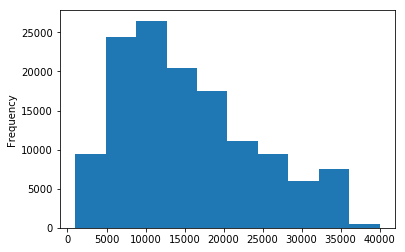

int_rate
Axes(0.125,0.125;0.775x0.755)


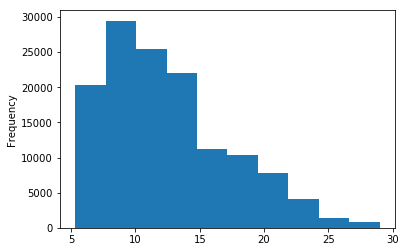

annual_inc
Axes(0.125,0.125;0.775x0.755)


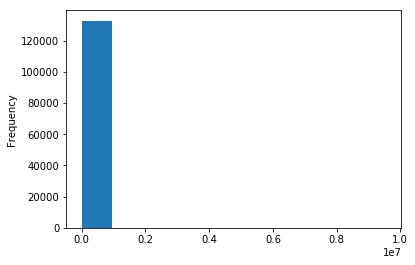

emp_length
Axes(0.125,0.125;0.775x0.755)


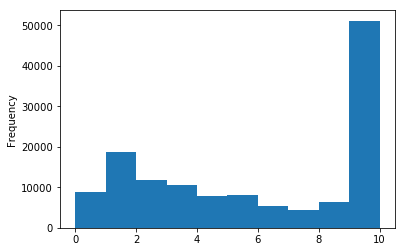

dti
Axes(0.125,0.125;0.775x0.755)


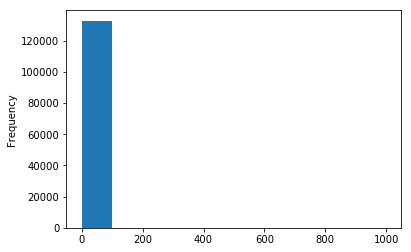

delinq_2yrs
Axes(0.125,0.125;0.775x0.755)


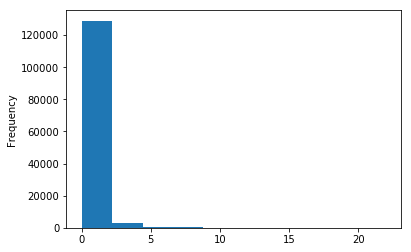

pub_rec_bankruptcies
Axes(0.125,0.125;0.775x0.755)


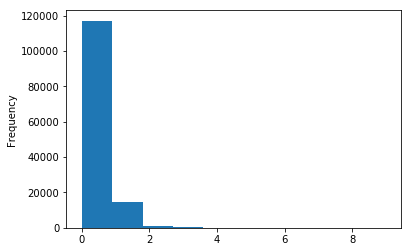

all_util
Axes(0.125,0.125;0.775x0.755)


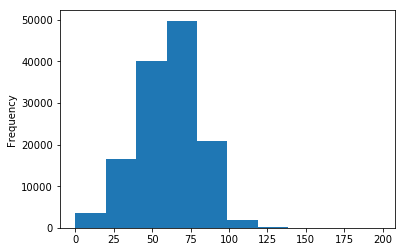

num_accts_ever_120_pd
Axes(0.125,0.125;0.775x0.755)


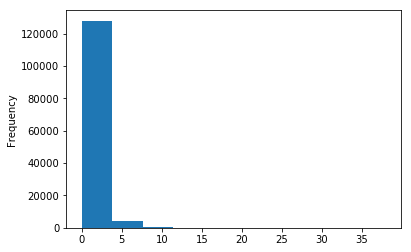

percent_bc_gt_75
Axes(0.125,0.125;0.775x0.755)


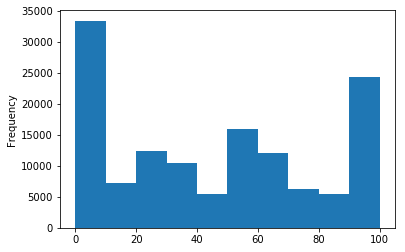

num_bc_tl
Axes(0.125,0.125;0.775x0.755)


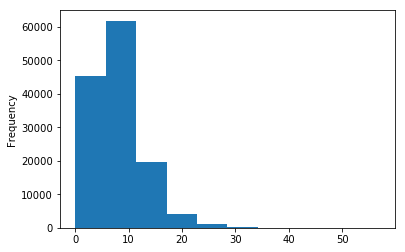

num_il_tl
Axes(0.125,0.125;0.775x0.755)


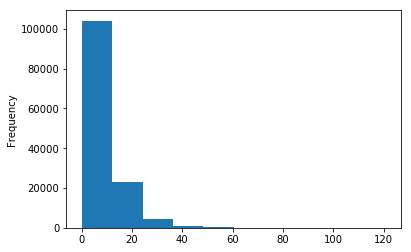

num_rev_accts
Axes(0.125,0.125;0.775x0.755)


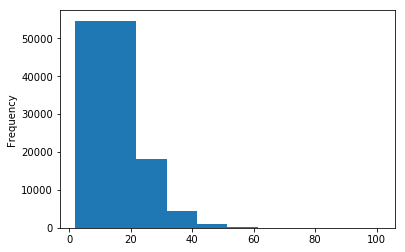

tax_liens
Axes(0.125,0.125;0.775x0.755)


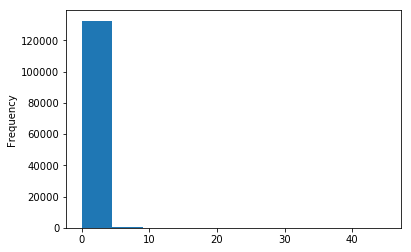

pct_tl_nvr_dlq
Axes(0.125,0.125;0.775x0.755)


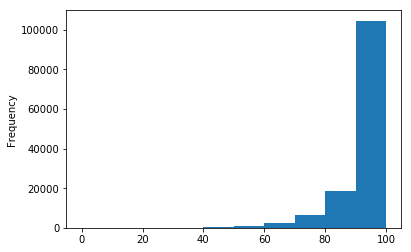

inq_last_12m
Axes(0.125,0.125;0.775x0.755)


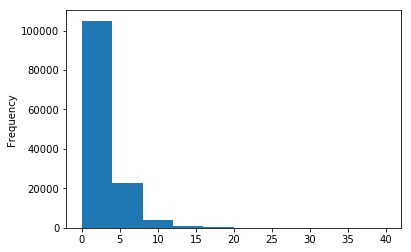

mo_sin_rcnt_tl
Axes(0.125,0.125;0.775x0.755)


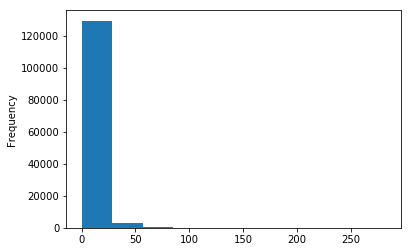

In [67]:

#let's plot histograms of all the numerical variables to inspect for possible problematic outliers
non_categorical_vars =['loan_amnt','int_rate','annual_inc','emp_length','dti','delinq_2yrs','pub_rec_bankruptcies',
'all_util','num_accts_ever_120_pd','percent_bc_gt_75','num_bc_tl','num_il_tl','num_rev_accts','tax_liens','pct_tl_nvr_dlq',
'inq_last_12m','mo_sin_rcnt_tl']


for i in non_categorical_vars:
    print(str(i))
    print(loan_subset[i].plot(kind = 'hist'))
    plt.show()

    

#through inspection of the histograms in addition to descriptive statistics provided in the previous cell, it is
#obvious that outliers are present for most of the variables. However, these outliers don't appear to be a result
#of data entry error, but rather as a result of random variation. For example, annual income has a large outlier 
#for the maximum value, but that is logical because some people have large annual incomes. Moreover, in spite of
#these outliers, the median and mean values for all of the variables track closely together, indicating that these
#large values don't distort the central tendency that much. It is important to note however, that virtually of the
#distributions are positively skewed; this is due to the fact that none of these variables can ever be less than zero.
#for example, annual income, number of accounts 120 past due, number of bankruptcies, etc. can never be negative.
#In addition, we are dealing with a lot of imbalanced data; there are generally going to be many more zero values than
#values above zero for variables like pub_rec_bankruptcies, num_accts_ever_120_pd, delinq_2yrs, tax_liens
#as these are generally rare events.
    
   
                    
                    

In [ ]:
#now we'll plot all the categorical variables, except zip_code    
categorical_vars = ['grade', 'home_ownership','loan_status','purpose','verification_status']

for v in non_categorical_vars:
    print(str(v))
    print(loan_subset[v].plot(kind = 'hist'))
    plt.show()                   


In [33]:
for col in loan_subset.columns:
    print(loan_subset[col].describe()) 
    print(' ')
    
#upon review of each column, it appears that more changes are needed.
#zip_code has too many unique values to work with, and dti has a negative minimum value.
# We will group zip_code into regional categories by the first digit (7 = southwest,
#0 = northeast, etc.), and remove the negative value from dti.

count    132918.000000
mean      15611.988406
std        8855.915934
min        1000.000000
25%        8500.000000
50%       14400.000000
75%       21000.000000
max       40000.000000
Name: loan_amnt, dtype: float64
 
count    132918.000000
mean         12.464539
std           4.824084
min           5.320000
25%           8.490000
50%          11.990000
75%          15.310000
max          28.990000
Name: int_rate, dtype: float64
 
count     132918
unique         7
top            B
freq       40029
Name: grade, dtype: object
 
count    132918.000000
mean          5.755541
std           3.792557
min           0.000000
25%           2.000000
50%           6.000000
75%          10.000000
max          10.000000
Name: emp_length, dtype: float64
 
count       132918
unique           3
top       MORTGAGE
freq         66305
Name: home_ownership, dtype: object
 
count    1.329180e+05
mean     8.051558e+04
std      7.777827e+04
min      2.000000e+02
25%      4.969487e+04
50%      6.800000e+04
75%

In [ ]:
#remove negative min value 
loan_subset = loan_subset[loan_subset['dti'] >=0 ]


In [115]:
# Here are the states according to the first digit of the zip code (given by wikipedia):
# 0 = Connecticut (CT), Massachusetts (MA), Maine (ME), New Hampshire (NH), New Jersey (NJ), New York (NY, Fishers Island only),
# Puerto Rico (PR), Rhode Island (RI), Vermont (VT), Virgin Islands (VI), Army Post Office Europe (AE), 
# Fleet Post Office Europe (AE)

# 1 = Delaware (DE), New York (NY), Pennsylvania (PA)

# 2 = District of Columbia (DC), Maryland (MD), North Carolina (NC), South Carolina (SC), Virginia (VA), West Virginia (WV)

# 3 = Alabama (AL), Florida (FL), Georgia (GA), Mississippi (MS), Tennessee (TN), Army Post Office Americas (AA), 
# Fleet Post Office Americas (AA)

#4 = Indiana (IN), Kentucky (KY), Michigan (MI), Ohio (OH)

#5 = Iowa (IA), Minnesota (MN), Montana (MT), North Dakota (ND), South Dakota (SD), Wisconsin (WI) 

#6 = Illinois (IL), Kansas (KS), Missouri (MO), Nebraska (NE)

#7 = Arkansas (AR), Louisiana (LA), Oklahoma (OK), Texas (TX)

#8 = Arizona (AZ), Colorado (CO), Idaho (ID), New Mexico (NM), Nevada (NV), Utah (UT), Wyoming (WY)

#9 = Alaska (AK), American Samoa (AS), California (CA), Guam (GU), Hawaii (HI), Marshall Islands (MH), 
#Federated States of Micronesia (FM), Northern Mariana Islands (MP), Oregon (OR), Palau (PW), Washington (WA), 
#Army Post Office Pacific (AP), Fleet Post Office Pacific (AP)

# The states in each group are generally in the same region of the country, so let's reassign each digit according to region
# some digits will overlap with respect to region, so multiple digits will have the same region.

# 0 = 'Northeast', 1 = 'Northeast', 2 = 'South Atlantic', 3 = 'Southeast', 4 = 'Midwest', 5 = 'Midwest'
# 6 = 'Midwest', 7 = 'Southwest', 8 = 'Mountain', 9 = 'West'

regions = {0:'Northeast', 1: 'Northeast', 2:'South Atlantic', 3:'Southeast', 4:'Midwest', 
           5:'Midwest', 6:'Midwest', 7:'Southwest', 8:'Mountain', 9:'West'}

#print(loan_subset['zip_code'].head())
#print(loan_subset['zip_code'].str[:1].head())

loancopy = loan_subset['zip_code'].copy()
loancopy = loancopy.str[:1].head()


x = loancopy.astype('int')
#print(x.head())

#print(regions.get(x[0]))

print(x.replace(x[0],regions.get(x[0]))) #THIS WORKED!!!

#def reg_map():
   # x = x.replace(x, regions.get(x))

#x.apply(lambda n: .replace()    )


0    Southeast
1            1
2            1
3            6
4            9
Name: zip_code, dtype: object


In [111]:
for i in x:
    x.replace(x[i],regions.get(x[i]))
    
print(x)

KeyError: 6

Purpose of Loans
debt_consolidation    76135
credit_card           32049
home_improvement       8544
other                  7006
major_purchase         2887
medical                1435
small_business         1368
car                    1288
moving                  752
vacation                729
house                   537
renewable_energy         81
Name: purpose, dtype: int64
Axes(0.125,0.125;0.775x0.755)


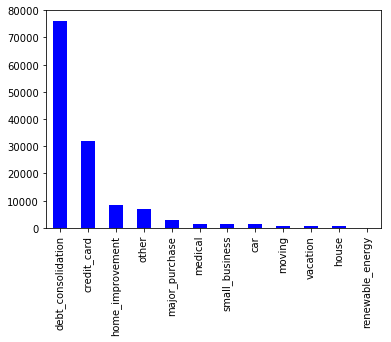

Loan Grade
B    39999
C    36498
A    26324
D    16267
E     9419
F     3430
G      874
Name: grade, dtype: int64
Axes(0.125,0.125;0.775x0.755)


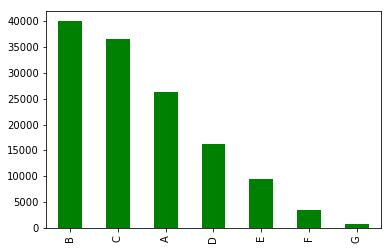

Years of Employment
10+ years    45938
2 years      11777
3 years      10664
< 1 year     10007
Unknown       8745
1 year        8647
5 years       8009
4 years       7739
8 years       6287
6 years       5332
9 years       5170
7 years       4424
n/a             72
Name: emp_length, dtype: int64
Axes(0.125,0.125;0.775x0.755)


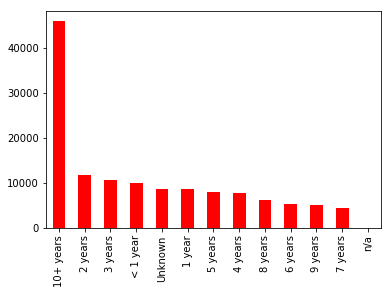

Living Arrangement
MORTGAGE    66259
RENT        50514
OWN         16038
Name: home_ownership, dtype: int64
Axes(0.125,0.125;0.775x0.755)


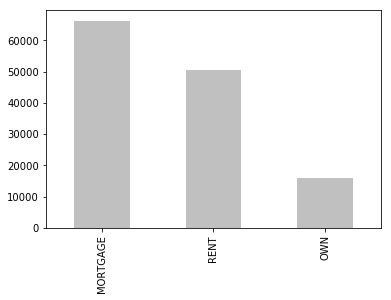

Verification Status
Source Verified    50003
Not Verified       46778
Verified           36030
Name: verification_status, dtype: int64
Axes(0.125,0.125;0.775x0.755)


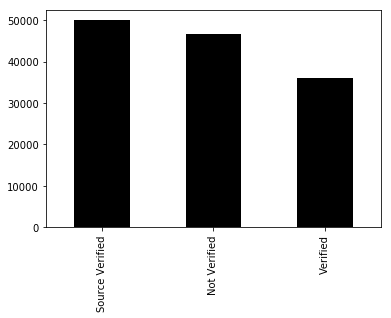

Loan Status
Current               63794
Fully Paid            48121
Charged Off           17651
Late (31-120 days)     1884
In Grace Period         912
Late (16-30 days)       444
Default                   5
Name: loan_status, dtype: int64
Axes(0.125,0.125;0.775x0.755)


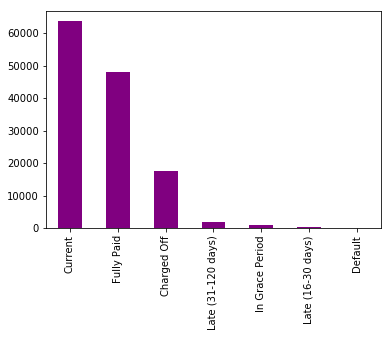

In [91]:
#let's find out the different loan purposes. let's put this code into a function so that we can do multiple plots quickly
print("Purpose of Loans")
print(loan_subset['purpose'].value_counts())
print(loan_subset['purpose'].value_counts().plot(kind = 'bar', color = 'blue'))
plt.show()
#it appears that the vast majority of loans are taken out for debt consolidation


print("Loan Grade")
print(loan_subset['grade'].value_counts())
print(loan_subset['grade'].value_counts().plot(kind = 'bar', color = 'green'))
plt.show()

print("Years of Employment")
print(loan_subset['emp_length'].value_counts())
print(loan_subset['emp_length'].value_counts().plot(kind = 'bar', color = 'red'))
plt.show()


print("Living Arrangement")
print(loan_subset['home_ownership'].value_counts())
print(loan_subset['home_ownership'].value_counts().plot(kind = 'bar', color = 'silver'))
plt.show()

print("Verification Status")
print(loan_subset['verification_status'].value_counts())
print(loan_subset['verification_status'].value_counts().plot(kind = 'bar', color = 'black'))
plt.show()


print("Loan Status")
print(loan_subset['loan_status'].value_counts())
print(loan_subset['loan_status'].value_counts().plot(kind = 'bar', color = 'purple'))
plt.show()